In [8]:
import numpy as np
import os
import sys

# Get the absolute path of the parent directory of the current file (which is 'test')
# current_dir = os.getcwd()
# model_path = os.path.join(current_dir, '..', 'model')
# sys.path.append(model_path)
sys.path.append('..')

from model.Force import HullForce, ControlForce, TowingForce
from model.RigidBody import RigidBody
from model.Simulation import Simulation, Simulation_Result

In [9]:
# Set parameters
m = 0.877 # kg
Vol = 733159.45810955 * 10 ** (-9)
Iyy = 6610.17475482 * 10 * (-6)
hull_surface_area = 0.1

r_xi = -111.76 * 10 ** (-3)
r_zi = 0.722 * 10 ** (-3)

r_xh = 0
r_zh = 0

r_xb = 0
r_zb = 0

r_xt = 42.9 * 10 ** (-3)
r_zt = -35.18 * 10 ** (-3)

rho = 1000

# Aero foil parameters
A = 2.61
C_L_a = 1 / 5 
C_D_0 = 0.02



In [10]:
rigidbody = RigidBody(m, Vol, Iyy, np.array([r_xb, r_zb]))
towForce = TowingForce(np.array([r_xt,r_zt]),10,np.deg2rad(30))
controlForce = ControlForce(np.array([r_xi,r_zi]),np.deg2rad(-5),A,C_L_a,C_D_0)
hullForce = HullForce(hull_surface_area,np.array([r_xh,r_zh]))

sim = Simulation(rigidbody,towForce,hullForce,[controlForce])



In [11]:
pitch_angle = -6
sim.initialize_system(initial_state=np.array([0, 0, 0, 2, 0, 0, 0, 0, 0]))
# Solve forces
sim.solve_forces(0)

# Calculate sum of forces/moments
total_force_x, total_force_z = sim.rigidbody.sum_forces(pitch_angle) 
total_moment_y = sim.rigidbody.sum_moments(pitch_angle)

print(total_force_x)
print(total_force_z)
print(total_moment_y)

-268.1015206499935
31.59876512040063
8.952059728301544


In [12]:
print(controlForce.magnitude)

[104.58898872 -82.91972406]


In [13]:
print(hullForce.magnitude)

[180.   0.]


In [14]:
# results = sim.solve_equilibrium_state_fsolve_fixed_delta_i(2, 5)
# results = sim.solve_equilibrium_state_fsolve_fixed_pitch(5, -6)


In [15]:
results = sim.solve_equilibrium_state_sqrt(2)

Optimization Results:
----------------------
Parameter       Value           Units     
----------------------
Pitch Angle     -4.00           degrees   
Delta_t         10.83           degrees   
Towing Force    293.75          N         
Delta_i         -3.69           degrees   
----------------------
Fx constraint   -0.00           N         
Fz constraint   -0.00           N         
My constraint   0.00            Nm        
Objective Function Value: 4.6201826120280987e-10
Optimization successful!


In [17]:
results = sim.solve_equilibrium_state_min_FT(2)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 293.7472273786522
            Iterations: 9
            Function evaluations: 45
            Gradient evaluations: 9
Optimization Results:
----------------------
Parameter       Value           Units     
----------------------
Pitch Angle     -4.00           degrees   
Delta_t         10.83           degrees   
Towing Force    293.75          N         
Delta_i         -3.69           degrees   
----------------------
Fx constraint   -0.00           N         
Fz constraint   -0.00           N         
My constraint   0.00            Nm        
Objective Function Value: 293.7472273786522
Optimization successful!


In [18]:
results = sim.solve_equilibrium_state_LS(2)

Optimization Results:
----------------------
Parameter       Value           Units     
----------------------
Pitch Angle     -4.21           degrees   
Delta_t         10.71           degrees   
Towing Force    293.81          N         
Delta_i         -3.68           degrees   
----------------------
Fx:             0.00           N         
Fz:             -0.00          N         
My:             0.00           Nm        
Residual Norm: 0.000000
Optimization successful!


Optimization Results:
----------------------
Parameter       Value           Units     
----------------------
Pitch Angle     -7.00           degrees   
Delta_t         9.11            degrees   
Towing Force    294.55          N         
Delta_i         -3.52           degrees   
----------------------
Fx:             0.00           N         
Fz:             -0.00          N         
My:             0.01           Nm        
Residual Norm: 0.000016
Optimization successful!
Optimization Results:
----------------------
Parameter       Value           Units     
----------------------
Pitch Angle     -5.45           degrees   
Delta_t         10.00           degrees   
Towing Force    294.18          N         
Delta_i         -3.61           degrees   
----------------------
Fx:             0.00           N         
Fz:             0.00           N         
My:             -0.00          Nm        
Residual Norm: 0.000003
Optimization successful!
Optimization Results:
----------------

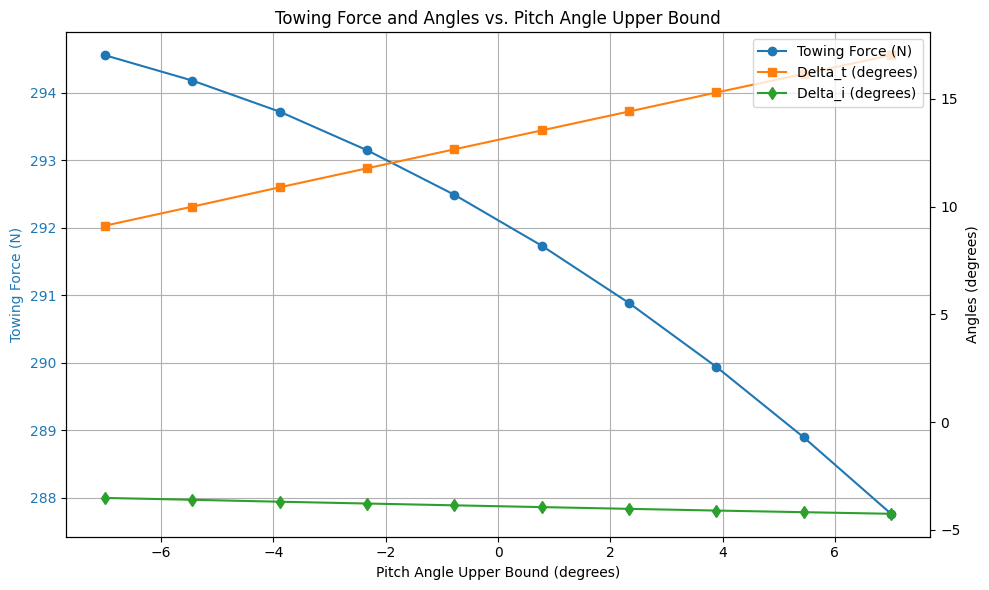

In [19]:
import matplotlib.pyplot as plt

# Generate pitch angle upper bounds (in radians)
pitch_angle_upper_bounds = np.linspace(-7, 7, 10)  # 10 points from -7 to 7 degrees

# Initialize arrays for results
towForces = np.zeros_like(pitch_angle_upper_bounds)
delta_ts = np.zeros_like(pitch_angle_upper_bounds)
delta_is = np.zeros_like(pitch_angle_upper_bounds)

# Run the simulation for each upper bound
for i, pitch_angle_ub in enumerate(pitch_angle_upper_bounds):
    sim.ub_pitch_angle = np.deg2rad(pitch_angle_ub)  # Convert to radians
    sim.lb_pitch_angle = np.deg2rad(pitch_angle_ub - 0.01)  # Lower bound in radians
    sim.bounds[0] = (sim.lb_pitch_angle, sim.ub_pitch_angle)
    result_LS = sim.solve_equilibrium_state_LS(2)  # Simulate and retrieve results

    # Store results
    delta_ts[i] = np.rad2deg(result_LS[1])  # Convert to degrees
    towForces[i] = result_LS[2]  # Force in N
    delta_is[i] = np.rad2deg(result_LS[3])  # Convert to degrees

# Create the figure and twin axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot towing force on the primary y-axis
ax1.plot(pitch_angle_upper_bounds, towForces, 'o-', color='tab:blue', label='Towing Force (N)')
ax1.set_xlabel('Pitch Angle Upper Bound (degrees)')
ax1.set_ylabel('Towing Force (N)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True)

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot delta_t and delta_i on the secondary y-axis
ax2.plot(pitch_angle_upper_bounds, delta_ts, 's-', color='tab:orange', label='Delta_t (degrees)')
ax2.plot(pitch_angle_upper_bounds, delta_is, 'd-', color='tab:green', label='Delta_i (degrees)')

ax2.set_ylabel('Angles (degrees)', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Adjust layout and show the plot
plt.title('Towing Force and Angles vs. Pitch Angle Upper Bound')
plt.tight_layout()
plt.show()
